In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from __future__ import division

%matplotlib inline
%load_ext autoreload 

In [2]:
# Default figure size
plt.rcParams['figure.figsize'] = (12,6)
%autoreload 2
from utilities import *

In [3]:
# ReLu check
Z  = np.array([[3,-10],[4,0]])
relu(Z)

array([[3, 0],
       [4, 0]])

In [4]:
# ReLu gradient check
Z = np.array([[-5,5,0],[4,-9,2]])
relu_grad(Z)

array([[0., 1., 0.],
       [1., 0., 1.]])

In [5]:
# Tanh Gradient
Z = np.array([[2,4],[-0,-1]])
print "Tanh grad value from function:\n", tanh_grad(Z)

Tanh grad value from function:
[[0.07065082 0.00134095]
 [1.         0.41997434]]


In [6]:
# softmax sanity check
# Sum along each column should be = 1
Z = np.array([[3,6,9],[5,4,9]])
print "Softmax Output:\n",softmax(Z)
print "Sum along columns: %s" %(np.sum(softmax(Z),axis=0))

Softmax Output:
[[0.11920292 0.88079708 0.5       ]
 [0.88079708 0.11920292 0.5       ]]
Sum along columns: [1. 1. 1.]


In [7]:
# Random parameter initialization
# Xavier initialization for Tanh activation 
# He initialization for Relu activation

def params_init(layers_dims,af='relu'):
    
    params = {}
    L = len(layers_dims) -1 # the number of layers
    
    if af == 'tanh':
        for l in range(1,L+1):
            params['W'+str(l)] = (np.random.randn(layers_dims[l],layers_dims[l-1])
                                      * np.sqrt(1/layers_dims[l-1]))
            params['b'+str(l)] = np.zeros((layers_dims[l],1))
            
            assert(params['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
            assert(params['b' + str(l)].shape == (layers_dims[l], 1))

                                
    else:
        for l in range(1,L+1):
            params['W'+str(l)] = (np.random.randn(layers_dims[l],layers_dims[l-1])
                                      * np.sqrt(2/layers_dims[l-1]))
            params['b'+str(l)] = np.zeros((layers_dims[l],1))
            
            assert(params['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
            assert(params['b' + str(l)].shape == (layers_dims[l], 1))
                                
    return params 

In [8]:
# Sanity check of params_init
params = params_init([2, 4,1])
print"W1 =\n %s" %(params['W1'])
print"b1 =\n %s" %(params['b1'])
print"W2 =\n %s" %(params['W2'])
print"b2 =\n %s" %(params['b2'])

W1 =
 [[-1.31362907 -1.45978354]
 [-0.64000984 -1.65547006]
 [-1.71180837  0.34954756]
 [ 0.72144477  1.06891653]]
b1 =
 [[0.]
 [0.]
 [0.]
 [0.]]
W2 =
 [[-0.09815691  0.02500262 -1.09479451  0.47170373]]
b2 =
 [[0.]]


In [9]:
# Forward Propagation
def forward_prop(X,params,af='relu'):
    
    caches = {}
    A = X
    caches['A'+str(0)] = X
    L = len(params) // 2  # number of layers in the network  
    for l in range(1,L): # Forward prop of (L-1) layers
        A_prev = A
        #Z(l) = W(l) * Aprev + b(l)
        Z = np.dot(params['W'+str(l)],A_prev) + params['b'+str(l)]
        assert(Z.shape == (params['W'+str(l)].shape[0],A.shape[1]))
        caches['Z'+str(l)] = Z 
        # Activation according to 'af'
        if af == 'tanh':
            A = np.tanh(Z)
            caches['A'+str(l)] = A
        else:
            A = relu(Z)
            caches['A'+str(l)] = A
    
    # Forward Prop of the output layer (L)
    Z = np.dot(params['W'+str(L)],A) + params['b'+str(L)]
    assert(Z.shape == (params['W'+str(L)].shape[0],A.shape[1]))
    caches['Z'+str(L)] = Z 
    
    if(Z.shape[0]==1):       # Sigmoid (Binary Classification )
        AL = sigmoid(Z)
        
    else:                   # Softmax  (Multiclass Classification)
        AL = softmax(Z)
    
    return AL,caches

In [10]:
# forward prop sanity check
X = np.array([[5,7,10,0],[2,3,5,1]])
print "Temp Data (X):\n",X
output,caches = forward_prop(X,params)
print"\nOutput from forward_prop:\n",output

Temp Data (X):
[[ 5  7 10  0]
 [ 2  3  5  1]]

Output from forward_prop:
[[0.93761209 0.98005818 0.99733303 0.53034495]]


In [11]:
# Displaying the dict 'caches' to be required for backprop
caches.items()

[('A1', array([[ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.34954756],
         [ 5.74505693,  8.256863  , 12.55903038,  1.06891653]])),
 ('A0', array([[ 5,  7, 10,  0],
         [ 2,  3,  5,  1]])),
 ('Z1', array([[ -9.48771241, -13.57475409, -20.43520837,  -1.45978354],
         [ -6.51098932,  -9.44647906, -14.6774487 ,  -1.65547006],
         [ -7.85994673, -10.93401591, -15.3703459 ,   0.34954756],
         [  5.74505693,   8.256863  ,  12.55903038,   1.06891653]])),
 ('Z2', array([[2.70996478, 3.89479308, 5.92414147, 0.12152916]]))]

In [12]:
# Function to compute cost
def cost_func(AL,Y,reg=0):
    
    cost =0
    if AL.shape[0] == 1:  # Binary (sigmoid) classification
        cost = -np.mean((Y*np.log(AL)) + ((1-Y)*np.log(1-AL)))
       
    else:  # Multiclass (softmax) classifiaction
        cost = np.mean(-np.sum(Y*np.log(AL),axis=0))
        
    cost += reg/AL.shape[1]  # Accomodating the Regularization Term
    
    return cost

In [13]:
Y = np.array([1,0,1,0]).reshape(1,-1)
print "Temp Labels (Y):\n", Y
cost = cost_func(output,Y)
print "\nCost for temp X and Y:\n",cost

Temp Labels (Y):
[[1 0 1 0]]

Cost for temp X and Y:
1.1844456769532745


In [14]:
# Performs the actual gradient computation
def compute_grads(dZ,grads,params,caches,l,m,lamb):
    
    dW = (1/m)* np.dot(dZ,caches['A'+str(l-1)].T) + (lamb/m)*params['W'+str(l)]
    assert (dW.shape == params['W'+str(l)].shape)
    grads['dW'+str(l)] = dW
    db = (1/m)* np.sum(dZ,axis=1,keepdims=True)
    assert (db.shape == params['b'+str(l)].shape)
    grads['db'+str(l)] = db
    dA_prev = np.dot(params['W'+str(l)].T,dZ)
    assert(dA_prev.shape == caches['A'+str(l-1)].shape)
    grads['dA'+str(l-1)] = dA_prev
    
    return grads

In [15]:
# Backpropagation
def backprop(AL,Y,caches,params,lamb=0,af='relu'):
    grads = {}
    L = len(params) //2
    m = AL.shape[1]
    # Backprop of the first layer
    dZ = AL-Y
    grads = compute_grads(dZ,grads,params,caches,L,m,lamb)
    
    # Backprop of other layers
    for l in reversed(range(1,L)):
        
        dA = grads['dA'+str(l)]
        if af =='tanh':
            dZ = dA * tanh_grad(caches['Z'+str(l)])
        else:
            dZ = dA * relu_grad(caches['Z'+str(l)])     
        assert(dZ.shape == caches['Z'+str(l)].shape)
        grads = compute_grads(dZ,grads,params,caches,l,m,lamb) 
        
    del grads['dA0']   # Deleting 'dA0', since not required  
    return grads

In [16]:
# Displaying the dict 'grads' which consists of the computed gradients
grads = backprop(output,Y,caches,params)
grads

{'dA1': array([[ 6.12380468e-03, -9.61994839e-02,  2.61781609e-04,
         -5.20570222e-02],
        [-1.55986116e-03,  2.45040210e-02, -6.66812522e-05,
          1.32600126e-02],
        [ 6.83019429e-02, -1.07296232e+00,  2.91978492e-03,
         -5.80618741e-01],
        [-2.94286106e-02,  4.62297101e-01, -1.25802004e-03,
          2.50165692e-01]]), 'dW1': array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        , -0.14515469],
        [ 0.76908911,  0.39297742]]), 'dW2': array([[0.        , 0.        , 0.0463452 , 2.06679599]]), 'db1': array([[ 0.        ],
        [ 0.        ],
        [-0.14515469],
        [ 0.17044404]]), 'db2': array([[0.36133706]])}

In [17]:
# Perform gradient checking using Numerical Gradient Estimation  
# to check our implementation of backprop
def grad_check(X,Y,params,grads,lamb=0,af='relu'):
    
    epsilon = 1e-7
    L = len(params) // 2
    theta,theta_grads = dict_to_vector(params,grads)
    num_params = theta.size
    J_plus = np.zeros((num_params,1))
    J_minus = np.zeros((num_params,1))
    grad_approx = np.zeros((num_params,1))
    
    for i in range(num_params):
        
        thetaplus = np.copy(theta)
        thetaplus[i] += epsilon
        thetaplus_dict = vector_to_dict(thetaplus,params)
        ALplus, _ = forward_prop(X,thetaplus_dict,af)
        reg_term = l2regularization(thetaplus_dict,lamb)
        J_plus[i] = cost_func(ALplus,Y,reg_term)
    
        thetaminus = np.copy(theta)
        thetaminus[i] -= epsilon
        thetaminus_dict = vector_to_dict(thetaminus,params)
        ALminus, _ = forward_prop(X,thetaminus_dict,af)
        reg_term = l2regularization(thetaminus_dict,lamb)
        J_minus[i] = cost_func(ALminus,Y,reg_term)
        
        grad_approx[i] = (J_plus[i] - J_minus[i])/(2*epsilon)
    
    numerator = np.linalg.norm(theta_grads-grad_approx)                              
    denominator = np.linalg.norm(theta_grads) + np.linalg.norm(grad_approx)                         
    difference = numerator/denominator 
    
    if difference > 2e-6:
        print ("\033[91m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
        
    

In [18]:
# Adam optimization algorithm for updating weights
def update_parameters_with_adam(params, grads, v, s, t, alpha = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
   
    
    L = len(params) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         
    
    for l in range(L):
        
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1-beta1)*grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1-beta1)*grads["db" + str(l+1)]
       
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1-beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1-beta1**t)
        
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1-beta2)*(grads["dW" + str(l+1)]**2 )
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1-beta2)*(grads["db" + str(l+1)]**2 )
       
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1-beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1-beta2**t)
       
        params["W" + str(l+1)] = params["W" + str(l+1)] - (alpha*(v_corrected["dW" + str(l+1)])/
                                      (np.sqrt(s_corrected["dW" + str(l+1)])+epsilon))
        params["b" + str(l+1)] = params["b" + str(l+1)] - (alpha*(v_corrected["db" + str(l+1)])/
                                      (np.sqrt(s_corrected["db" + str(l+1)])+epsilon))
       

    return params, v, s

In [19]:
# Function to compute the l2 regularization of weights (only W's)
def l2regularization(params,lamb=0):
    
    L = len(params) // 2
    total = 0 
    
    for l in range(L):
        total += np.sum(params['W'+str(l+1)]**2)
    
    reg_term = (lamb/2)*total
    return reg_term    

In [20]:
reg = l2regularization(params,0.01)
print 'Value computed from l2regularization:  ', reg
# Sanity checking l2regularization 
total = (0.01/2)*(np.sum(params['W1']**2) + np.sum(params['W2']**2))
print '\nValue from Sanity Check:\t\t', total

Value computed from l2regularization:   0.06576829424625606

Value from Sanity Check:		0.06576829424625606


In [21]:
# Loading Binary data
Data = np.load("Data.npz")
Data.files

['X', 'labels']

In [22]:
# Assinging the samples to 'X' and labels to 'y'
X = Data['X']
y = Data['labels'].reshape(1,-1)
print "Dimensions of X (Features(n) x Examples(m)):",X.shape
print "\nDiemsions of y:",y.shape

Dimensions of X (Features(n) x Examples(m)): (2, 400)

Diemsions of y: (1, 400)


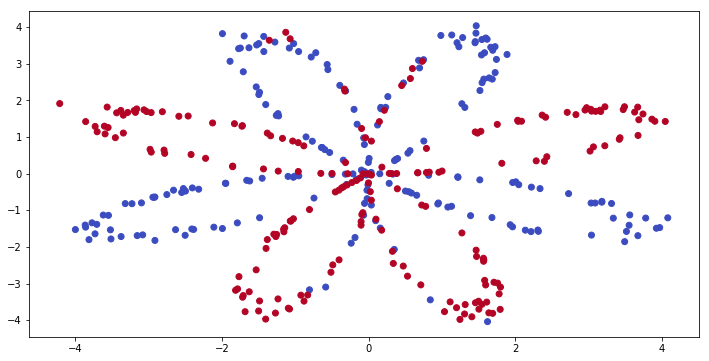

In [23]:
# Visualizing the data
plt.scatter(X[0], X[1], c=y.ravel(), cmap=plt.cm.coolwarm)
plt.show()

In [24]:
# Function to implement a Neural Network
def model (X,Y,layer_dims,iteration=6000,alpha=0.01,lamb=0,af='relu'):
    
    params= params_init(layer_dims,af)
    v,s = init_for_adam(params)
    t=0
    hist_cost = []
    for i in range(iteration):
        AL,caches = forward_prop(X,params,af)
        reg_term = l2regularization(params,lamb)
        cost = cost_func(AL,Y,reg_term) 
        hist_cost.append(cost)
        
        grads = backprop(AL,Y,caches,params,lamb,af)
         
        if i%500 == 0:
            print "Cost after iteration %i: %f" %(i, cost)
            grad_check(X,Y,params,grads,lamb,af)
            #print reg_term
            
        t += 1
        params,v,s = update_parameters_with_adam(params,grads,v,s,t,alpha)
        
    print "Cost after iteration %i: %f" %(i, cost) 
    plt.plot(np.squeeze(hist_cost))
    plt.ylabel('Cost')
    plt.xlabel('Itertaions')
    plt.title('Learing Rate = '+ str(alpha))
    plt.show()
        
    return params

Cost after iteration 0: 0.827473
Your backward propagation works perfectly fine! difference = 3.08590569775023e-09
Cost after iteration 500: 0.336838
Your backward propagation works perfectly fine! difference = 2.0987269098817538e-08
Cost after iteration 1000: 0.286807
Your backward propagation works perfectly fine! difference = 2.6449793478479732e-08
Cost after iteration 1500: 0.268223
Your backward propagation works perfectly fine! difference = 5.303072063072978e-08
Cost after iteration 2000: 0.257216
Your backward propagation works perfectly fine! difference = 8.08341799288554e-08
Cost after iteration 2500: 0.249295
Your backward propagation works perfectly fine! difference = 6.09174672835618e-08
Cost after iteration 3000: 0.243007
Your backward propagation works perfectly fine! difference = 1.0225550039563906e-07
Cost after iteration 3500: 0.237798
Your backward propagation works perfectly fine! difference = 1.3406640538947148e-07
Cost after iteration 4000: 0.233512
Your backward p

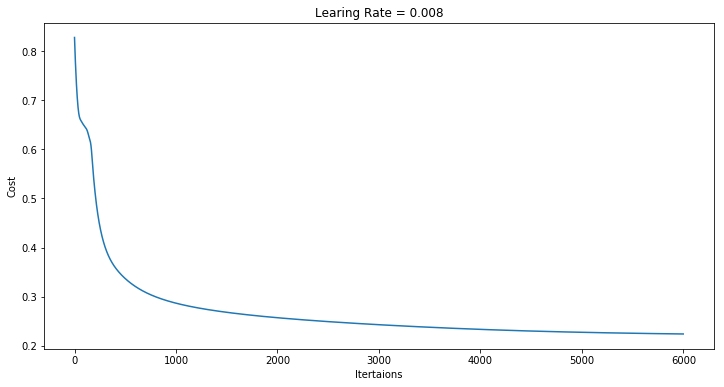

In [25]:
# Implementing a Neural Net for Binary Classification
# 2 layer NN 
# Planar data i.e 2-Dimensions fed as input
# 4 units in the hidden layer
# 1 output unit
# Using tanh activation function
af = 'tanh'
layer_dims = [X.shape[0],4,1]
params = model(X,y,layer_dims,alpha=0.008,af=af)

In [26]:
# Function to predict the class for each sample (binary)
def predict_binary(X,parameters,af):
    AL,_ = forward_prop(X,parameters,af)
    AL = AL>0.5
          
    return AL 

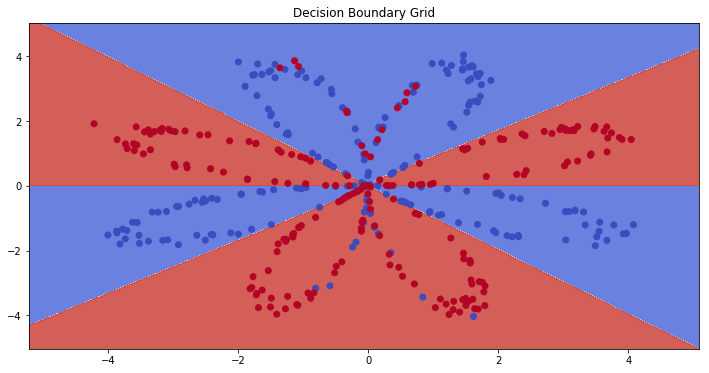

In [27]:
# Plotting the Decision Boundary Grid created by the n/w
xx,yy,Z = grid(X)
Z = predict_binary(Z,params,af)
plt.contourf(xx, yy, Z.reshape(xx.shape), alpha=0.85, cmap=plt.cm.coolwarm)
plt.scatter(X[0], X[1], c=y.ravel(), cmap=plt.cm.coolwarm)
plt.title("Decision Boundary Grid")
plt.show()

In [28]:
# Getting the predictions from the network and calculating the accuracy
pred_y = predict_binary(X,params,af)
acc = np.mean(pred_y.flatten()==y.flatten())*100
print('Accuracy on the dataset: %s %%' %round(acc,2))

Accuracy on the dataset: 91.0 %


In [29]:
# Loading the Multiclass Data
# N: number of points per class
# K: number of classes
X2,y2 = multiClass_Data(N=200,K=3)

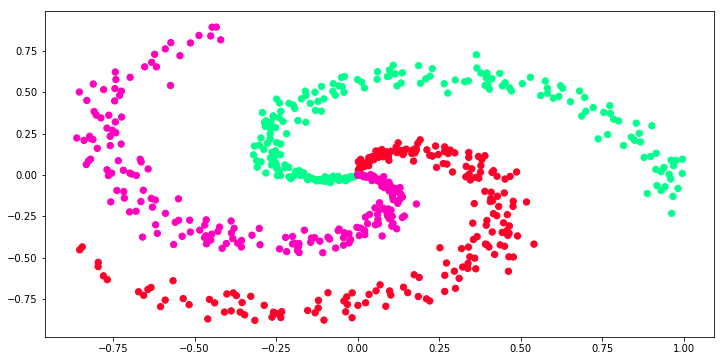

In [30]:
# lets visualize the data:
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=40, cmap=plt.cm.gist_rainbow)
plt.show()

In [31]:
X2 = X2.T  # Reshaping as (n x m)
# Converting to one hot matrix
y2_hot = one_hot(y2)

Cost after iteration 0: 1.134101
Your backward propagation works perfectly fine! difference = 1.332916325307066e-08
Cost after iteration 500: 0.237042
Your backward propagation works perfectly fine! difference = 6.90193287781473e-08
Cost after iteration 1000: 0.225116
Your backward propagation works perfectly fine! difference = 1.7384017061928533e-07
Cost after iteration 1199: 0.223704


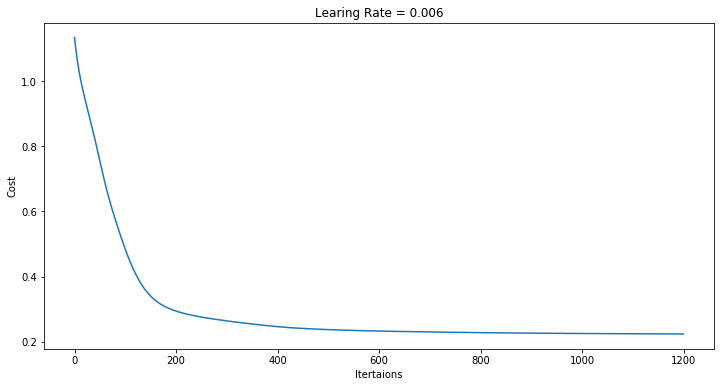

In [32]:
# Implementing a Neural Net for Multiclass Classification with regularization
# 3 layer NN 
# Planar data i.e 2-Dimensions fed as input
# 14 units in the first hidden layer , 4 in the second hidden layer
# No. of classes = 3 units in the output layer
# Using ReLu activation function
af2 = 'relu'
layer_dims2 = [X2.shape[0],14,4,y2_hot.shape[0]]
params2 = model(X2,y2_hot,layer_dims2,alpha=0.006,lamb=1.6,iteration=1200,af=af2)

In [33]:
# Function to predict the class for each example (multiclass)
def predict_multiClass(X2,params2,af2):
    AL,_ = forward_prop(X2,params2,af2)
    pred = np.argmax(AL,axis=0)
    return pred

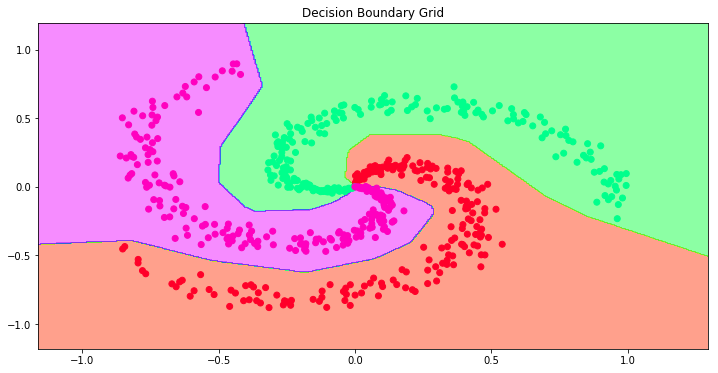

In [34]:
# Plotting the Decision Boundary Grid created by the n/w
xx,yy,Z = grid(X2,0.3)
Z = predict_multiClass(Z,params2,af2)
plt.contourf(xx, yy, Z.reshape(xx.shape), alpha=0.45, cmap=plt.cm.gist_rainbow)
plt.scatter(X2[0], X2[1], c=y2, cmap=plt.cm.gist_rainbow)
plt.title("Decision Boundary Grid")
plt.show()

In [35]:
# Getting the predictions from the network and calculating the accuracy
pred_y2 = predict_multiClass(X2,params2,af2)
acc = np.mean(pred_y2.flatten()==y2.flatten())*100
print('Accuracy on the dataset: %s %%' %round(acc,2))

Accuracy on the dataset: 99.5 %
